<a href="https://colab.research.google.com/github/vincenzodentamaro/aucoresnet/blob/main/AUCO_ResNet_Official_Tensorflow_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kapre==0.3.4
#pip install git https://github.com/user/repo.git@branch
!pip install --upgrade tf_siren
!pip install --upgrade googledrivedownloader

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 462 kB 5.1 MB/s 
  Created wheel for kapre: filename=kapre-0.3.4-py3-none-any.whl size=20613 sha256=cb7e5a03e7a974414f374a1224f0a93196b5225a002b83981424c9d1db42aa0d
  Stored in directory: /root/.cache/pip/wheels/b2/8d/b6/6748d12a58294a1dec4a709629713d60e3c935be2bd67bb465
Successfully built kapre
  Attempting uninstall: kapre
    Found existing installation: kapre 0.3.7
    Uninstalling kapre-0.3.7:
      Successfully uninstalled kapre-0.3.7


In [2]:
print('Running in 1-thread CPU mode for fully reproducible results training a CNN and generating numpy randomness.  This mode may be slow...')
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 1

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
seed_value += 1

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
seed_value += 1

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
seed_value += 1

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
 

Running in 1-thread CPU mode for fully reproducible results training a CNN and generating numpy randomness.  This mode may be slow...


This is a toy dataset extracted from Virufy (it is not the full Virufy dataset), thus accuracies are unreliable and not untruthful

In [3]:
!git clone https://github.com/vincenzodentamaro/aucoresnet.git
!unzip aucoresnet/virufy_pickle.zip

Cloning into 'aucoresnet'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.
Archive:  aucoresnet/virufy_pickle.zip
  inflating: Virufy_cough_noSplit_POS.p  
  inflating: Virufy_cough_noSplit_NEG.p  


In [4]:
import pickle
cam_task1_pos = pickle.load( open( "Virufy_cough_noSplit_POS.p", "rb" ) )
cam_task1_neg = pickle.load( open( "Virufy_cough_noSplit_NEG.p", "rb" ) )

SAMPLING_RATE = 22050


In [5]:
X = []
y = []
patientids = []
for value in cam_task1_pos:
    patientid = value['id']
    for audio in value['audio']:
        X.append(audio)
        y.append(1.0)
        patientids.append(patientid)
        
for value in cam_task1_neg:
    patientid = value['id']
    for audio in value['audio']:
        X.append(audio)
        y.append(0.0)
        patientids.append(patientid)
'''

for value in cos_breath_pos:
    patientid = value['id']
    for audio in value['audio']:
        X.append(audio)
        y.append(1.0)
        patientids.append(patientid)
        
for value in cos_breath_neg:
    patientid = value['id']
    for audio in value['audio']:
        X.append(audio)
        y.append(0.0)
        patientids.append(patientid)
'''




"\n\nfor value in cos_breath_pos:\n    patientid = value['id']\n    for audio in value['audio']:\n        X.append(audio)\n        y.append(1.0)\n        patientids.append(patientid)\n        \nfor value in cos_breath_neg:\n    patientid = value['id']\n    for audio in value['audio']:\n        X.append(audio)\n        y.append(0.0)\n        patientids.append(patientid)\n"

Mean secs
13.732426303854876
Max secs
19.340045351473922


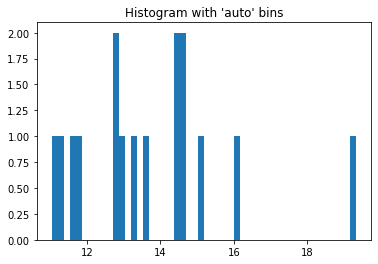

In [6]:
import numpy as np
import matplotlib.pyplot as plt

lunghezze = []
for r in X:
  lunghezze.append(len(r))

print('Mean secs')
print(np.mean(lunghezze)/SAMPLING_RATE)
print('Max secs')
print(np.max(lunghezze)/SAMPLING_RATE)
_ = plt.hist(np.asarray(lunghezze)/SAMPLING_RATE, bins=50)  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [7]:
import numpy as np
import librosa
max_length = 15.#in secs
max_samples =  max_length*SAMPLING_RATE
for i in range(len(X)):

  temp = X[i]
  #temp = librosa.resample(temp, 20000, 16000)
  temp = np.reshape(temp,(1,temp.shape[0]))  
  
  if temp.shape[1] < max_samples:
    
    offset = max_samples - len(temp)

    shape = np.shape(temp)
    tt = np.zeros((1,int(max_samples)))
    tt[:shape[0],:shape[1]] = temp

    temp = tt
    
     
  if temp.shape[1] > max_samples:
    temp = temp[0,:int((max_samples))]
    temp = np.reshape(temp,(1,temp.shape[0]))  
  X[i] = temp
  
  print(temp.shape)
lens = []
for it in X:
  lens.append(it.shape[1])



print('Mean secs')
print(np.mean(lens)/SAMPLING_RATE)
print('Max secs')
print(np.max(lens)/SAMPLING_RATE)

(1, 330750)
(1, 330750)
(1, 330750)
(1, 330750)
(1, 330750)
(1, 330750)
(1, 330750)
(1, 330750)
(1, 330750)
(1, 330750)
(1, 330750)
(1, 330750)
(1, 330750)
(1, 330750)
(1, 330750)
(1, 330750)
Mean secs
15.0
Max secs
15.0


In [8]:
import math
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random
rand = random.Random(42)
#Dentamaro et al.
def inter_patient_scheme(X_,lbls_,filenames, test_size = 0.2):
  people_index = {}
  people_class = {}
  X = copy.deepcopy(X_)
  lbls = copy.deepcopy(lbls_)
  
  for i in range(len(filenames)):
        
      usercode = filenames[i]
      if not usercode in people_class:
        people_class[usercode] = lbls[i]
      #print(usercode)
      if usercode in people_index:
        people_index[usercode].append(i)
      else:
        people_index[usercode] = []
        people_index[usercode].append(i)
  #print(people_index)    
  keys = list(people_index.keys())

  rand.shuffle(keys)
  #print(keys) 
  

  peoples_in_train = math.floor(len(keys)*(1.-test_size))
  people_in_test = len(keys)-peoples_in_train
  temp_classes = []
  j = 0
  for k in keys:
    if j < peoples_in_train:
      temp_classes.append(people_class[k])
    j += 1

  unique, counts = np.unique(temp_classes, return_counts=True)
  min_index = np.where(counts == np.min(counts))
  min_people = np.min(counts)
  min_class = unique[min_index]
  print('minority class '+str(min_class))
  print('minority people '+str(min_people))






  #print(peoples_in_train)
  training_items = []
  testing_items = []

  class_counter = {}

  train_usercodes = []
  test_usercodes = []
  #per people balance 
  for j in range(peoples_in_train):
    index = people_index[keys[j]]
    
    this_class = people_class[keys[j]]
    #print(this_class)
    #print(class_counter)
    if not this_class in class_counter:
      class_counter[this_class] = 0
    
    if this_class != min_class and class_counter[this_class] < min_people:      
      for h in index:
        training_items.append(h)
        train_usercodes.append(keys[j])
      class_counter[this_class] += 1
    elif this_class != min_class and class_counter[this_class] >= min_people :
       for h in index:
          pass
          #testing_items.append(h)
       #class_counter[this_class] += 1
    else:
      for h in index:
        training_items.append(h)
        train_usercodes.append(keys[j])
      class_counter[this_class] += 1
  
  temp_classes = []
  j = 0
  for k in keys:
    if j >= peoples_in_train:
      temp_classes.append(people_class[k])
    j += 1

  #print(temp_classes)
  class_counter = {}
  unique, counts = np.unique(temp_classes, return_counts=True)
  min_index = np.where(counts == np.min(counts))
  min_people = np.min(counts)
  min_class = unique[min_index]
  #print(min_people)
  #print(min_class)
  for j in range(peoples_in_train, len(keys)):
    index = people_index[keys[j]]
    
    this_class = people_class[keys[j]]
    #print(this_class)
    #print(class_counter)
    if not this_class in class_counter:
      class_counter[this_class] = 0
    
    if this_class != min_class[0] and class_counter[this_class] < min_people:      
      for h in index:
        testing_items.append(h)
        test_usercodes.append(keys[j])
        #print('Negative index --> '+str(h))
      
      class_counter[this_class] += 1
    elif this_class == min_class[0]:
      for h in index:
        testing_items.append(h)
        test_usercodes.append(keys[j])
        #print('Positive index --> '+str(h))
    
  

  
  testing_items = np.asarray(testing_items)
  training_items = np.asarray(training_items)
  #lbls = np.asarray(lbls)
  yy = to_categorical(lbls)
  X_train = X[training_items,:]
  y_train = yy[training_items,:]
  X_test = X[testing_items,:]
  y_test = yy[testing_items,:]
  #print(y_test)
  ffn = np.asarray(filenames)[training_items]

  #for j in range(len(lbls)):
    #print(str(yy[j])+ ' --> '+str(lbls[j]))

  return X_train, X_test, y_train, y_test,train_usercodes, test_usercodes


    

    

    

In [9]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Conv1D, Add, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid
from tf_siren import SinusodialRepresentationDense, Sine
def attach_attention_module(net, attention_module, activation=Activation('relu'), ratio = 8):
  if attention_module == 'se_block': # SE_block
    net = se_block(net, activation=activation, ratio=ratio)
  elif attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net, activation=activation, ratio=ratio)
  elif attention_module == 'dbam_block': # CBAM_block
    net = dbam_block(net, activation=activation)
  elif attention_module == 'eca_block': # CBAM_block
    net = ecanet(net)
  else:
    pass
  return net

def se_block(input_feature, ratio=8, activation='relu'):
	"""Contains the implementation of Squeeze-and-Excitation(SE) block.
	As described in https://arxiv.org/abs/1709.01507.
	"""
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	se_feature = GlobalAveragePooling2D()(input_feature)
	se_feature = Reshape((1, 1, channel))(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)

  
	se_feature = Dense(channel // ratio,
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	se_feature  = Activation(activation)(se_feature)


	#se_feature = SinusodialRepresentationDense(channel // ratio,activation='sine', w0=1.0)(se_feature)#72 auc
	assert se_feature.shape[1:] == (1,1,channel//ratio)
	se_feature = Dense(channel,
					   activation='sigmoid',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	if K.image_data_format() == 'channels_first':
		se_feature = Permute((3, 1, 2))(se_feature)

	se_feature = multiply([input_feature, se_feature])
	return se_feature
def dbam_block(cbam_feature, ratio=8, activation='relu'):

	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = se_block(cbam_feature, ratio)#channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature
	 
def cbam_block(cbam_feature, ratio=8, activation='relu'):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature
	 

def ecanet(input_feature,gamma=2,b=1,):
  channel_axis = 1 if K.image_data_format() == "channels_first" else -1
  channels = input_feature.shape[channel_axis]
  t = int(abs((math.log(channels,2)+b)/gamma))
  k = t if t%2 else t+1
  x_global_avg_pool = GlobalAveragePooling2D()(input_feature)
  x = Reshape((channels,1))(x_global_avg_pool)
  x = Conv1D(1,kernel_size=k,padding="same")(x)
  x = Activation('sigmoid')(x)  #shape=[batch,chnnels,1]
  x = Reshape((1, 1, channels))(x)
  output = multiply([input_feature,x])
  return output


def channel_attention(input_feature, ratio=8,activation='relu'):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation=activation,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature,activation='relu'):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])
		
"""Backend operations of Kapre.

This module summarizes operations and functions that are used in Kapre layers.

Attributes:
    _CH_FIRST_STR (str): 'channels_first', a pre-defined string.
    _CH_LAST_STR (str): 'channels_last', a pre-defined string.
    _CH_DEFAULT_STR (str): 'default', a pre-defined string.

"""
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import librosa
import tensorflow
#tensorflow.random.set_seed(42)

_CH_FIRST_STR = 'channels_first'
_CH_LAST_STR = 'channels_last'
_CH_DEFAULT_STR = 'default'


def get_window_fn(window_name=None):
    """Return a window function given its name.
    This function is used inside layers such as `STFT` to get a window function.

    Args:
        window_name (None or str): name of window function. On Tensorflow 2.3, there are five windows available in
        `tf.signal` (`hamming_window`, `hann_window`, `kaiser_bessel_derived_window`, `kaiser_window`, `vorbis_window`).

    """

    if window_name is None:
        return tf.signal.hann_window

    available_windows = {
        'hamming_window': tf.signal.hamming_window,
        'hann_window': tf.signal.hann_window,
    }
    if hasattr(tf.signal, 'kaiser_bessel_derived_window'):
        available_windows['kaiser_bessel_derived_window'] = tf.signal.kaiser_bessel_derived_window
    if hasattr(tf.signal, 'kaiser_window'):
        available_windows['kaiser_window'] = tf.signal.kaiser_window
    if hasattr(tf.signal, 'vorbis_window'):
        available_windows['vorbis_window'] = tf.signal.vorbis_window

    if window_name not in available_windows:
        raise NotImplementedError(
            'Window name %s is not supported now. Currently, %d windows are'
            'supported - %s'
            % (
                window_name,
                len(available_windows),
                ', '.join([k for k in available_windows.keys()]),
            )
        )

    return available_windows[window_name]


def validate_data_format_str(data_format):
    """A function that validates the data format string."""
    if data_format not in (_CH_DEFAULT_STR, _CH_FIRST_STR, _CH_LAST_STR):
        raise ValueError(
            'data_format should be one of {}'.format(
                str([_CH_FIRST_STR, _CH_LAST_STR, _CH_DEFAULT_STR])
            )
            + ' but we received {}'.format(data_format)
        )


def magnitude_to_decibel(x, ref_value=1.0, amin=1e-5, dynamic_range=80.0):
    """A function that converts magnitude to decibel scaling.
    In essence, it runs `10 * log10(x)`, but with some other utility operations.

    Similar to `librosa.amplitude_to_db` with `ref=1.0` and `top_db=dynamic_range`

    Args:
        x (`Tensor`): float tensor. Can be batch or not. Something like magnitude of STFT.
        ref_value (`float`): an input value that would become 0 dB in the result.
            For spectrogram magnitudes, ref_value=1.0 usually make the decibel-scaled output to be around zero
            if the input audio was in [-1, 1].
        amin (`float`): the noise floor of the input. An input that is smaller than `amin`, it's converted to `amin`.
        dynamic_range (`float`): range of the resulting value. E.g., if the maximum magnitude is 30 dB,
            the noise floor of the output would become (30 - dynamic_range) dB

    Returns:
        log_spec (`Tensor`): a decibel-scaled version of `x`.

    Note:
        In many deep learning based application, the input spectrogram magnitudes (e.g., abs(STFT)) are decibel-scaled
        (=logarithmically mapped) for a better performance.

    Example:
        ::

            input_shape = (2048, 1)  # mono signal
            model = Sequential()
            model.add(kapre.Frame(frame_length=1024, hop_length=512, input_shape=input_shape))
            # now the shape is (batch, n_frame=3, frame_length=1024, ch=1)

    """

    def _log10(x):
        return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=x.dtype))

    if K.ndim(x) > 1:  # we assume x is batch in this case
        max_axis = tuple(range(K.ndim(x))[1:])
    else:
        max_axis = None

    if amin is None:
        amin = 1e-5

    log_spec = 10.0 * _log10(tf.math.maximum(x, amin))
    log_spec = log_spec - 10.0 * _log10(tf.math.maximum(amin, ref_value))

    log_spec = tf.math.maximum(
        log_spec, tf.math.reduce_max(log_spec, axis=max_axis, keepdims=True) - dynamic_range
    )

    return log_spec


def filterbank_mel(
    sample_rate, n_freq, n_mels=128, f_min=0.0, f_max=None, htk=False, norm='slaney',trainable=False, num_classes=2
):
    """A wrapper for librosa.filters.mel that additionally does transpose and tensor conversion

    Args:
        sample_rate (`int`): sample rate of the input audio
        n_freq (`int`): number of frequency bins in the input STFT magnitude.
        n_mels (`int`): the number of mel bands
        f_min (`float`): lowest frequency that is going to be included in the mel filterbank (Hertz)
        f_max (`float`): highest frequency that is going to be included in the mel filterbank (Hertz)
        htk (bool): whether to use `htk` formula or not
        norm: The default, 'slaney', would normalize the the mel weights by the width of the mel band.

    Returns:
        (`Tensor`): mel filterbanks. Shape=`(n_freq, n_mels)`
    """

    filterbank = librosa.filters.mel(
        sr=sample_rate,
        n_fft=(n_freq - 1) * 2,
        n_mels=n_mels,
        fmin=f_min,
        fmax=f_max,
        htk=htk,
        norm=norm,
    ).astype(K.floatx())

    ff = filterbank.T
    print('FF shape',ff.shape)
    
    if trainable:
      variables = []
      for i in range(num_classes):
        #variables.append(tf.Variable(tf.ones(shape=(ff.shape[0],ff.shape[1]), dtype=tf.float32),trainable=True, name='kernel_variable_'+str(i))*tf.Variable(ff,trainable=False))
        variables.append(tf.Variable(ff,trainable=True))

      
      ff = tf.add_n(variables)# / num_classes #* tf.Variable(tf.convert_to_tensor(ff),trainable=False)
      

    print('Trainable mel spectrogram is '+str(trainable))
    return ff


def filterbank_log(sample_rate, n_freq, n_bins=84, bins_per_octave=12, f_min=None, spread=0.125, trainable = False):
    """A function that returns a approximation of constant-Q filter banks for a fixed-window STFT.
    Each filter is a log-normal window centered at the corresponding frequency.

    Args:
        sample_rate (`int`): audio sampling rate
        n_freq (`int`): number of the input frequency bins. E.g., `n_fft / 2 + 1`
        n_bins (`int`): number of the resulting log-frequency bins.  Defaults to 84 (7 octaves).
        bins_per_octave (`int`): number of bins per octave. Defaults to 12 (semitones).
        f_min (`float`): lowest frequency that is going to be included in the log filterbank. Defaults to `C1 ~= 32.70`
        spread (`float`): spread of each filter, as a fraction of a bin.

    Returns:
        (`Tensor`): log-frequency filterbanks. Shape=`(n_freq, n_bins)`

    Note:
        The code is originally from `logfrequency` in librosa 0.4 (deprecated) and copy-and-pasted.
        `tuning` parameter was removed and we use `n_freq` instead of `n_fft`.
    """

    if f_min is None:
        f_min = 32.70319566

    f_max = f_min * 2 ** (n_bins / bins_per_octave)
    if f_max > sample_rate // 2:
        raise RuntimeError(
            'Maximum frequency of log filterbank should be lower or equal to the maximum'
            'frequency of the input (defined by its sample rate), '
            'but f_max=%f and maximum frequency is %f. \n'
            'Fix it by reducing n_bins, increasing bins_per_octave and/or reducing f_min.\n'
            'You can also do it by increasing sample_rate but it means you need to upsample'
            'the input audio data, too.' % (f_max, sample_rate)
        )

    # What's the shape parameter for our log-normal filters?
    sigma = float(spread) / bins_per_octave

    # Construct the output matrix
    basis = np.zeros((n_bins, n_freq))

    # Get log frequencies of bins
    log_freqs = np.log2(librosa.fft_frequencies(sample_rate, (n_freq - 1) * 2)[1:])

    for i in range(n_bins):
        # What's the center (median) frequency of this filter?
        c_freq = f_min * (2.0 ** (float(i) / bins_per_octave))

        # Place a log-normal window around c_freq
        basis[i, 1:] = np.exp(
            -0.5 * ((log_freqs - np.log2(c_freq)) / sigma) ** 2 - np.log2(sigma) - log_freqs
        )

    # Normalize the filters
    basis = librosa.util.normalize(basis, norm=1, axis=1)
    basis = basis.astype(K.floatx())
    print('Trainable mel spectrogram is '+str(trainable))
    return tf.Variable(tf.convert_to_tensor(basis.T), trainable=trainable)


def mu_law_encoding(signal, quantization_channels):
    """Encode signal based on mu-law companding. Also called mu-law compressing.

    This algorithm assumes the signal has been scaled to between -1 and 1 and returns a signal encoded
    with values from 0 to quantization_channels - 1.
    See `Wikipedia <https://en.wikipedia.org/wiki/Μ-law_algorithm>`_ for more details.

    Args:
        signal (float `Tensor`): audio signal to encode
        quantization_channels (positive int): Number of channels. For 8-bit encoding, use 256.

    Returns:
        signal_mu (int `Tensor`): mu-encoded signal
    """
    mu = quantization_channels - 1.0
    signal_mu = tf.math.sign(signal) * tf.math.log1p(mu * tf.math.abs(signal)) / tf.math.log1p(mu)
    signal_mu = tf.cast(((signal_mu + 1) / 2.0 * mu + 0.5), tf.int32)
    return signal_mu


def mu_law_decoding(signal_mu, quantization_channels):
    """Decode mu-law encoded signals based on mu-law companding. Also called mu-law expanding.

    See `Wikipedia <https://en.wikipedia.org/wiki/Μ-law_algorithm>`_ for more details.

    Args:
        signal_mu (int `Tensor`): mu-encoded signal to decode
        quantization_channels (positive int): Number of channels. For 8-bit encoding, use 256.

    Returns:
        signal (float `Tensor`): decoded audio signal
    """
    mu = quantization_channels - 1.0
    signal_mu = K.cast_to_floatx(signal_mu)

    signal = (signal_mu / mu) * 2 - 1.0
    signal = (
        tf.math.sign(signal) * (tf.math.exp(tf.math.abs(signal) * tf.math.log1p(mu)) - 1.0) / mu
    )
    return signal



class ApplyFilterbank(tensorflow.keras.layers.Layer):
    """
    Apply a filterbank to the input spectrograms.
    Args:
        filterbank (`Tensor`): filterbank tensor in a shape of (n_freq, n_filterbanks)
        data_format (`str`): specifies the data format of batch input/output
        **kwargs: Keyword args for the parent keras layer (e.g., `name`)
    Example:
        ::
            input_shape = (2048, 1)  # mono signal
            n_fft = 1024
            n_hop = n_fft // 2
            kwargs = {
                'sample_rate': 22050,
                'n_freq': n_fft // 2 + 1,
                'n_mels': 128,
                'f_min': 0.0,
                'f_max': 8000,
            }
            model = Sequential()
            model.add(kapre.STFT(n_fft=n_fft, hop_length=n_hop, input_shape=input_shape))
            model.add(Magnitude())
            # (batch, n_frame=3, n_freq=n_fft // 2 + 1, ch=1) and dtype is float
            model.add(ApplyFilterbank(type='mel', filterbank_kwargs=kwargs))
            # (batch, n_frame=3, n_mels=128, ch=1)
    """

    def __init__(
        self, type, filterbank_kwargs, data_format='default', **kwargs,
    ):

        kapre.backend.validate_data_format_str(data_format)

        self.type = type
        self.filterbank_kwargs = filterbank_kwargs

        if type == 'log':
            self.filterbank = _log_filterbank = filterbank_log(**filterbank_kwargs)
        elif type == 'mel':
            self.filterbank = _mel_filterbank = filterbank_mel(**filterbank_kwargs)

        if data_format == _CH_DEFAULT_STR:
            self.data_format = K.image_data_format()
        else:
            self.data_format = data_format

        if self.data_format == _CH_FIRST_STR:
            self.freq_axis = 3
        else:
            self.freq_axis = 2
        super(ApplyFilterbank, self).__init__(**kwargs)

    def call(self, x):
        """
        Apply filterbank to `x`.
        Args:
            x (`Tensor`): float tensor in 2D batch shape.
        """

        # x: 2d batch input. (b, t, fr, ch) or (b, ch, t, fr)
        output = tf.tensordot(x, self.filterbank, axes=(self.freq_axis, 0))
        # ch_last -> (b, t, ch, new_fr). ch_first -> (b, ch, t, new_fr)
        if self.data_format == _CH_LAST_STR:
            output = tf.transpose(output, (0, 1, 3, 2))
        return output

    def get_config(self):
        config = super(ApplyFilterbank, self).get_config()
        config.update(
            {
                'type': self.type,
                'filterbank_kwargs': self.filterbank_kwargs,
                'data_format': self.data_format,
            }
        )
        return config

#AUCORESNET V2 
import tensorflow as tf
import tensorflow.keras
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Lambda, Activation, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, SeparableConv2D
from tensorflow.keras.layers import Concatenate, Add
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, LambdaCallback, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
import os
from tf_siren import SinusodialRepresentationDense, Sine
from matplotlib import pyplot as plt
from kapre.time_frequency import (
    STFT,
    InverseSTFT,
    Phase,
    MagnitudeToDecibel, 
    ConcatenateFrequencyMap,
    Magnitude
)
import kapre

from tensorflow import keras
from tensorflow.keras import Sequential, Model
#from spela.melspectrogram import Melspectrogram, Spectrogram

import math
class MagnitudeTR(Layer):

  def __init__(self, trainable, **kwargs):
    super(MagnitudeTR, self).__init__(**kwargs)
    self.trainable = trainable

    """Compute the magnitude of the complex input, resulting in a float tensor
    Example:
        ::
            input_shape = (2048, 1)  # mono signal
            model = Sequential()
            model.add(kapre.STFT(n_fft=1024, hop_length=512, input_shape=input_shape))
            mode.add(Magnitude())
            # now the shape is (batch, n_frame=3, n_freq=513, ch=1) and dtype is float
    """
  def build(self, input_shape):
        
        self.u = self.add_weight(  shape=(input_shape[3], 1), initializer='uniform',
                                   trainable=True)
        #self.kernel = self.add_weight(name='kernel',  initializer=tf.keras.initializers.GlorotUniform(), 
        #                               trainable=True,
                                      #shape=(input_shape[-1], input_shape[-2]))
        #                              shape=( input_shape[3], input_shape[2]))
        super(MagnitudeTR, self).build(input_shape)

  def call(self, x):
        """
        Args:
            x (complex `Tensor`): input complex tensor
        Returns:
            (float `Tensor`): magnitude of `x`
        """
        xr = tf.math.real(x)
        #xr = tf.reshape(xr,(tf.shape(xr)[0],tf.shape(xr)[1]))
        if self.trainable:
          xr = K.dot(xr,self.u)
          #xr = tf.reshape(xr,(tf.shape(xr)[1],tf.shape(xr)[0], 1))

        #tf.shape(xr)
        #xr = xr.numpy()
        xi = tf.math.imag(x)
        #xr1 = tf.Variable(xr,trainable=self.trainable)
        xb = tf.complex(xr,xi)
        #x = tf.Variable(lambda:tf.math.abs(x),trainable=self.trainable)
        
        return tf.abs(xb)
        #return tf.abs(x)
#from tensorflow.keras.utils.generic_utils import get_custom_objects

#get_custom_objects().update({'custom_activation': SineReLU()})
def sinc(x):
    tf.keras.activations.swish(x)
    #return  K.exp(-K.pow(x,2))
    #x = tf.where(tf.abs(x) < 1e-20, 1e-20 * tf.ones_like(x), x)
    #return tf.sin(x) / x

class AUCOResNetV2:
    def __init__(self, att='att2', gmode='concat', compatibilityfunction='pc', datasetname="covid", input_shape=(1,64000),
                 outputclasses=100, weight_decay=0.0005, optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'],
                 runs = [1, 8, 3, 5, 4], n_fft=1024,sample_rate=22050,n_mels=128, win_length =160, hop_length=344, 
                 return_decibel=True,input_data_format='channels_first', sinusoidal = False, trainable = True, pers_act = 'elu', attention_type='cbam_block',subsample_initial_block = True,strides=(2,2) , 
                 filters = 64, initial_kernel = (7, 7),debug=False):
        
        inputs = Input(shape=input_shape) #batch*x*y*3
        self.history = None

        #Layer 1
        '''
        if trainable:
          fft_base_2 = pow(2, math.ceil(math.log(n_fft)/math.log(2)));

          x = Melspectrogram(sr=sample_rate, n_mels=n_mels,n_dft=fft_base_2,  n_hop=hop_length, input_shape=input_shape,return_decibel_melgram=True, trainable_kernel=False,  trainable_fb=True) (inputs)
          #x = Spectrogram( n_dft=fft_base_2, n_hop=hop_length, input_shape=(input_shape), win_length=win_length, return_decibel_spectrogram=True, power_spectrogram=2.0, trainable_kernel=True, name='static_stft') (inputs)
          #x = Normalization2D(str_axis='freq')(x)
        else:
        '''
        x = self.get_melspectrogram_layer(name='mel',n_fft=n_fft,sample_rate=sample_rate,n_mels=n_mels, hop_length=hop_length, return_decibel=return_decibel,input_data_format=input_data_format,  trainable = trainable, num_classes=outputclasses) (inputs)      
        
        if debug:
          x = Conv2D(128,(1,1),  name='conv2dfirst')(x)
        #x2 = get_log_frequency_spectrogram_layer(n_fft=2048,log_n_bins=84, sample_rate=16000,hop_length=344,input_data_format='channels_first',return_decibel=True)(inputs)

        #x = keras.layers.Concatenate(axis=2)([x1,x2])#,x4])
       
        regularizer = keras.regularizers.l2(weight_decay)
        self.datasetname = datasetname
        self.outputclasses=outputclasses
        #x = BatchNormalization(epsilon=1.1e-5)(x)
        
        if sinusoidal == False:
            activ = pers_act
        else:
            print('ERROR --> Not implemented Sine Attention')
            activ = 'relu'


        if subsample_initial_block:
          
          initial_strides = strides
        else:
          
          initial_strides = (1, 1)

        x = Conv2D(filters, initial_kernel, kernel_initializer='he_normal', padding='same',
               strides=initial_strides, use_bias=False, kernel_regularizer=regularizer)(x)
        '''
        if subsample_initial_block:
          x = BatchNormalization(epsilon=1.1e-5)(x)
          if sinusoidal == False:
            x = Activation(pers_act)(x)
          else:
            x =Dentamaro(trainable=True)(x)
          x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
        '''
        x = attach_attention_module(x,'cbam_block',activation=activ, ratio = 2)
        #END LAYER 1

        #Layer 2
        #block1, out batch*(x)*(y)*16

        for i in range(0,runs[0]):
          #if i == 0:
          #   identity = Conv2D(filters,(2,2), padding='same', kernel_regularizer=regularizer, name='id1')(x)
          x = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=regularizer)(x)
          x = BatchNormalization(epsilon=1.1e-5)(x)
          if sinusoidal == False:
            x = Activation(pers_act)(x)
          else:
            x =Dentamaro(trainable=True)(x)
          #x = attach_attention_module(x,attention_type)
          x = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=regularizer)(x) #batch*x*y*16
          x = BatchNormalization(epsilon=1.1e-5)(x)
          if sinusoidal == False:
            x = Activation(pers_act)(x)
          else:
            x =Dentamaro(trainable=True)(x)
          #x = Add()([identity,x])
        x = attach_attention_module(x,attention_type,activation=activ)

        #x = Add()([identity,x])
        #END Layer 2
        
        #Layer 3
        #block2, out batch*(x/2)*(y/2)*64
        for i in range(0,runs[1]):#was 18
            identity = x
            if i == 0:
                identity=Conv2D(filters,(2,2), padding='same', kernel_regularizer=regularizer, name='block2dimchangeconv')(identity)
            x = Conv2D(int(filters/4), (1, 1), padding='same', kernel_regularizer=regularizer, name='block2resblock'+str((i+1))+'conv1')(x)
            x = BatchNormalization(epsilon=1.1e-5)(x)
            #x = Activation(pers_act)(x)
            if sinusoidal == False:
              x = Activation(pers_act)(x)
            else:
              x =Dentamaro(trainable=True)(x)
            x = Conv2D(int(filters/4), (3, 3), padding='same', kernel_regularizer=regularizer, name='block2resblock'+str((i+1))+'conv2')(x)
            x = BatchNormalization(epsilon=1.1e-5)(x)
            #x = Activation(pers_act)(x)
            if sinusoidal == False:
              x = Activation(pers_act)(x)
            else:
              x =Dentamaro(trainable=True)(x)
            x = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=regularizer, name='block2resblock'+str((i+1))+'conv3')(x)
            x = BatchNormalization(epsilon=1.1e-5)(x)
            x = attach_attention_module(x,attention_type,activation=activ)
            x = Add()([identity,x])
            #x = Activation(pers_act)(x)
            if sinusoidal == False:
              x = Activation(pers_act)(x)
            else:
              x =Dentamaro(trainable=True)(x)
        
        l1 = x #16 filters, 32x32 resolution
        f1 = filters
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block2pool')(x)

        #END Layer 3
        #Layer 4

        filters *= 2

        #block3, out batch*(x/4)*(y/4)*128
        for i in range(0,runs[2]):#was18
            identity = x
            if i == 0:
                identity=Conv2D(filters, (2,2), padding='same', kernel_regularizer=regularizer, name='block3dimchangeconv')(identity)            
            x = Conv2D(int(filters/4), (1, 1), padding='same', kernel_regularizer=regularizer, name='block3resblock'+str((i+1))+'conv1')(x)
            x = BatchNormalization(epsilon=1.1e-5)(x)
            #x = Activation(pers_act)(x)
            if sinusoidal == False:
              x = Activation(pers_act)(x)
            else:
              x =Dentamaro(trainable=True)(x)
            x = Conv2D(int(filters/4), (1, 1), padding='same', kernel_regularizer=regularizer, name='block3resblock'+str((i+1))+'conv2')(x)
            x = BatchNormalization(epsilon=1.1e-5)(x)
            #x = Activation(pers_act)(x)
            if sinusoidal == False:
              x = Activation(pers_act)(x)
            else:
              x =Dentamaro(trainable=True)(x)
            x = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=regularizer, name='block3resblock'+str((i+1))+'conv3')(x)
            x = BatchNormalization(epsilon=1.1e-5)(x)
            x = attach_attention_module(x,attention_type,activation=activ)
            x = Add()([identity,x])
            #x = Activation(pers_act)(x)
            if sinusoidal == False:
              x = Activation(pers_act)(x)
            else:
              x =Dentamaro(trainable=True)(x)
        f2 = filters
        l2 = x #256 filters, 16x16 resolution
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block3pool')(x)
        #END Layer 4

        #Layer 5
        filters *= 2
        #block4, out batch*(x/4)*(y/4)*256
        for i in range(0,runs[3]):#was18
            identity = x
            if i == 0:
                identity=Conv2D(filters, (2,2), padding='same', kernel_regularizer=regularizer, name='block4dimchangeconv')(identity)            
            x = Conv2D(int(filters/4), (1, 1), padding='same', kernel_regularizer=regularizer, name='block4resblock'+str((i+1))+'conv1')(x)
            x = BatchNormalization(epsilon=1.1e-5)(x)
            #x = Activation(pers_act)(x)
            if sinusoidal == False:
              x = Activation(pers_act)(x)
            else:
              x =Dentamaro(trainable=True)(x)
            x = Conv2D(int(filters/4), (3, 3), padding='same', kernel_regularizer=regularizer, name='block4resblock'+str((i+1))+'conv2')(x)
            x = BatchNormalization(epsilon=1.1e-5)(x)
            #x = Activation(pers_act)(x)
            if sinusoidal == False:
              x = Activation(pers_act)(x)
            else:
              x =Dentamaro(trainable=True)(x)
            x = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=regularizer, name='block4resblock'+str((i+1))+'conv3')(x)
            x = BatchNormalization(epsilon=1.1e-5)(x)
            x = attach_attention_module(x,attention_type,activation=activ)
            x = Add()([identity,x])
            #x = Activation(pers_act)(x)
            if sinusoidal == False:
              x = Activation(pers_act)(x)
            else:
              x =Dentamaro(trainable=True)(x)
        l3 = x #512 filters, 8x8 resolution
        f3 = filters
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block4pool')(x)#aggiunto
        #END Layer 5
        #Layer 6

        filters *= 2
        #block4, out batch*(x/4)*(y/4)*256
        for i in range(0,runs[4]):#was18
            identity = x
            if i == 0:
                identity=Conv2D(filters, (2,2), padding='same', kernel_regularizer=regularizer)(identity)            
            x = Conv2D(int(filters/4), (1, 1), padding='same', kernel_regularizer=regularizer)(x)
            x = BatchNormalization(epsilon=1.1e-5)(x)
            #x = Activation(pers_act)(x)
            if sinusoidal == False:
              x = Activation(pers_act)(x)
            else:
              x =Dentamaro(trainable=True)(x)
            x = Conv2D(int(filters/4), (3, 3), padding='same', kernel_regularizer=regularizer)(x)
            x = BatchNormalization(epsilon=1.1e-5)(x)
            #x = Activation(pers_act)(x)
            if sinusoidal == False:
              x = Activation(pers_act)(x)
            else:
              x =Dentamaro(trainable=True)(x)
            x = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=regularizer)(x)
            x = BatchNormalization(epsilon=1.1e-5)(x)
            x = attach_attention_module(x,attention_type,activation=activ)
            x = Add()([identity,x])
            #x = Activation(pers_act)(x)
            if sinusoidal == False:
              x = Activation(pers_act)(x)
            else:
              x =Dentamaro(trainable=True)(x) 
        l4 = x  
        f4 = filters
        
        x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=regularizer, name='outconv')(x) 
        x = BatchNormalization(epsilon=1.1e-5)(x)
        x = MaxPooling2D((2,2), strides=(2,2), name="gpool")(x)
        x = attach_attention_module(x,'cbam_block',activation=activ, ratio = 2)

        gbase = Flatten(name='pregflatten')(x)
        if True:
          g64 = SinusodialRepresentationDense(f1, activation='sine', w0=1.0)(gbase)#added now 0.406
          g128 = SinusodialRepresentationDense(f2, activation='sine', w0=1.0)(gbase)#added now 
          g256 = SinusodialRepresentationDense(f3, activation='sine', w0=1.0)(gbase)#added now 
          g4 = SinusodialRepresentationDense(f4, activation='sine', w0=1.0)(gbase)#added now 
        else:
          g64 = Dense(f1, kernel_regularizer=regularizer, name='globalg64',activation=pers_act)(gbase)
          g128 = Dense(f2, kernel_regularizer=regularizer, name='globalg128',activation=pers_act)(gbase)
          g256 = Dense(f3, kernel_regularizer=regularizer, name='globalg256',activation=pers_act)(gbase)    
          g4 = Dense(f4, kernel_regularizer=regularizer, name='globalg4',activation=pers_act)(gbase)       

        #Learnable attention
        c1 = ParametrisedCompatibility(kernel_regularizer=regularizer, name='cpc1')([l1, g64])  # batch*x*y
        if compatibilityfunction == 'mha':
            c1 =  tfa.layers.MultiHeadAttention(head_size=64, num_heads=12)([l1, g64])
        if compatibilityfunction == 'dp':
            c1 = Lambda(lambda lam: K.squeeze(K.map_fn(lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype='float32'), 3), name='cdp1')([l1, g64])  # batch*x*y
        flatc1 = Flatten(name='flatc1')(c1)  # batch*xy
        a1 = Activation('softmax', name='softmax1')(flatc1)  # batch*xy
        reshaped1 = Reshape((-1,f1), name='reshape1')(l1)  # batch*xy*256.
        if compatibilityfunction == 'mha':
            g1 = a1
        else:
            g1 = Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), name='g1')([a1, reshaped1])  # batch*256.
        
        c2 = ParametrisedCompatibility(kernel_regularizer=regularizer, name='cpc2')([l2, g128])
        if compatibilityfunction == 'mha':
            c2 =  tfa.layers.MultiHeadAttention(head_size=64, num_heads=12)([l2, g128])
        if compatibilityfunction == 'dp':
            c2 = Lambda(lambda lam: K.squeeze(K.map_fn(lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype='float32'), 3), name='cdp2')([l2, g128])
        flatc2 = Flatten(name='flatc2')(c2)
        a2 = Activation('softmax', name='softmax2')(flatc2)
        reshaped2 =  Reshape((-1,f2), name='reshape2')(l2)
        if compatibilityfunction == 'mha':
            g2 = a2
        else:
            g2 = Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), name='g2')([a2, reshaped2])

        c3 = ParametrisedCompatibility(kernel_regularizer=regularizer, name='cpc3')([l3, g256])
        if compatibilityfunction == 'mha':
            c3 =  tfa.layers.MultiHeadAttention(head_size=64, num_heads=12)([l3, g256])
        if compatibilityfunction == 'dp':
            c3 = Lambda(lambda lam: K.squeeze(K.map_fn(lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype='float32'), 3), name='cdp3')([l3, g256])
        flatc3 = Flatten(name='flatc3')(c3)
        a3 = Activation('softmax', name='softmax3')(flatc3)
        reshaped3 = Reshape((-1,f3), name='reshape3')(l3)
        if compatibilityfunction == 'mha':
            g3 = a3
        else:
            g3 = Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), name='g3')([a3, reshaped3])
        
        if runs[4] > 0:
          c4 = ParametrisedCompatibility(kernel_regularizer=regularizer, name='cpc4')([l4, g4])
          if compatibilityfunction == 'mha':
              c4 =  tfa.layers.MultiHeadAttention(head_size=64, num_heads=12)([l4, g4])
          if compatibilityfunction == 'dp':
              c4 = Lambda(lambda lam: K.squeeze(K.map_fn(lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype='float32'), 3), name='cdp4')([l4, g4])
          flatc4 = Flatten(name='flatc4')(c4)
          a4 = Activation('softmax', name='softmax4')(flatc4)
          reshaped4 = Reshape((-1,f4), name='reshape4')(l4)
          if compatibilityfunction == 'mha':
              g4_ = a4
          else:
              g4_ = Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), name='g4')([a4, reshaped4])

        out = ''
        if gmode == 'concat':
            if runs[4] > 0:
              glist = [g4_, g3, g2, g1]
            else:
              glist = [g3, g2, g1]
            predictedG = Concatenate(axis=1, name='ConcatG')(glist)
            x = Dense(outputclasses, kernel_regularizer=regularizer, name=str(outputclasses)+'ConcatG')(predictedG)
            out = Activation("softmax", name='concatsoftmaxout')(x)
            
        else:
            gd3 = Dense(outputclasses, activation='softmax', name=str(outputclasses)+'indepsoftmaxg3')(g3)
            gd4 = Dense(outputclasses, activation='softmax', name=str(outputclasses)+'indepsoftmaxg4')(g4_)
            gd2 = Dense(outputclasses, activation='softmax', kernel_regularizer=regularizer, name=str(outputclasses)+'indepsoftmaxg2')(g2)
            gd1 = Dense(outputclasses, activation='softmax', kernel_regularizer=regularizer, name=str(outputclasses)+'indepsoftmaxg1')(g1)
            if runs[4] > 0:
              out = Add(name='addg4g3g2g1')([gd1, gd2, gd3, gd4])
              out = Lambda(lambda lam: lam/4, name='4average')(out)
            else:
              out = Add(name='addg4g3g2g1')([gd1, gd2, gd3])
              out = Lambda(lambda lam: lam/3, name='4average')(out)

        #END Layer 6
        model = Model(inputs=inputs, outputs=out)
        
      

        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)#, run_eagerly=True)
        tf.keras.utils.plot_model(
            model, to_file='model.png', show_shapes=True, show_dtype=True,
            show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
        )
        name = ("(RN-"+att+")-"+gmode+"-"+compatibilityfunction).replace('att)', 'att1)')
        print("Generated "+name)
        self.name = name
        self.model = model
    
    def StandardFit(self, datasetname=None, X=[], Y=[],initial_lr=0.01, min_delta=None, patience=3, datagen = None, validation_data=None, lrplateaufactor=None, lrplateaupatience=4, validation_split=0.3,batch_size=16,epochs=100,checkpointcall=None, class_weights=None, monitor_early='val_auc'):
        #Y = keras.utils.to_categorical(Y,self.outputclasses)
        if datasetname==None:
            datasetname=self.datasetname
        if os.path.isfile("weights/"+self.name+"-"+datasetname+" early.hdf5"):
            print("Found early-stopped weights for "+self.name+"-"+datasetname)
            return
        scheduler = LearningRateScaler([20, 50, 80], 0.2, initial_lr)
        
        tboardcb = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=3, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
        if checkpointcall ==None:
            checkpoint = ModelCheckpoint("weights/"+self.name+"-"+datasetname+" {epoch}.hdf5", 
                                         save_weights_only=True,monitor='val_accuracy', mode='max', save_best_only=True)
        else:
            checkpoint = checkpointcall
        epochprint = LambdaCallback(on_epoch_end=lambda epoch, logs: print("Passed epoch "+str(epoch)))
        
        callbackslist = [ checkpoint, epochprint]#, tboardcb]
 
         
        if min_delta != None:
              callbackslist.append(EarlyStopping(monitor=monitor_early, min_delta=min_delta, patience=patience))
        if lrplateaufactor != None:
              callbackslist.append(ReduceLROnPlateau(monitor='auc', factor = lrplateaufactor, patience = lrplateaupatience))
        if lrplateaufactor != None:
              callbackslist.append(ReduceLROnPlateau(monitor='accuracy', factor = lrplateaufactor, patience = lrplateaupatience))
        if datagen != None:
          self.history = self.model.fit(datagen, epochs=epochs, callbacks=callbackslist, shuffle=False,
                               validation_data=(validation_data[0],validation_data[1]), verbose=1)
        else:  
          if validation_data == None:
              self.history = self.model.fit(X, Y,  batch_size=batch_size, epochs=epochs, 
                                            callbacks=callbackslist, shuffle=False,validation_split=validation_split, verbose=1, class_weight=class_weights)#,class_weight=class_weights)    
          else:
              self.history = self.model.fit(X, Y,  batch_size=batch_size, epochs=epochs, callbacks=callbackslist, shuffle=False,
                            validation_data=(validation_data[0],validation_data[1]), verbose=1, class_weight=class_weights)#,class_weight=class_weights)     
        
        
        return self.model
        
        
        return self.model
    
    def save_plot(self, filename, history=None, title='AUCO ResNet Accuracy'):
        
        if history == None:
            history = self.history
       
        plt.rcParams["figure.figsize"] = [16,9]
            
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        #plt.plot(history.history['loss'])
        #plt.plot(history.history['val_loss'])
        plt.plot(history.history['auc'])
        plt.plot(history.history['val_auc'])
            

        plt.title(title)
        plt.ylabel('Accuracy / AUC')
        plt.xlabel('epoch')
        plt.legend(['training accuracy', 'validation accuracy','training AUC','validation AUC'], loc='upper left')
        plt.savefig(filename, format="svg", cmap='nipy_spectral')
        f = plt.figure()
        f.clear()
        plt.close(f)
        plt.close('all')

 
    def get_melspectrogram_layer(self,
        input_shape=None,
        n_fft=2048,
        win_length=None,
        hop_length=None,
        window_name=None,
        pad_begin=False,
        pad_end=False,
        sample_rate=22050,
        n_mels=128,
        mel_f_min=0.0,
        mel_f_max=None,
        mel_htk=False,
        mel_norm='slaney',
        return_decibel=False,
        db_amin=1e-5,
        db_ref_value=1.0,
        db_dynamic_range=80.0,
        input_data_format='default',
        output_data_format='default',
        trainable = True,
        name='melspectrogram',
        num_classes=2,
    ):
        """A function that returns a melspectrogram layer, which is a `keras.Sequential` model consists of
        `STFT`, `Magnitude`, `ApplyFilterbank(_mel_filterbank)`, and optionally `MagnitudeToDecibel`.
        Args:
            input_shape (None or tuple of integers): input shape of the model. Necessary only if this melspectrogram layer is
                is the first layer of your model (see `keras.model.Sequential()` for more details)
            n_fft (int): number of FFT points in `STFT`
            win_length (int): window length of `STFT`
            hop_length (int): hop length of `STFT`
            window_name (str or None): *Name* of `tf.signal` function that returns a 1D tensor window that is used in analysis.
                Defaults to `hann_window` which uses `tf.signal.hann_window`.
                Window availability depends on Tensorflow version. More details are at `kapre.backend.get_window()`.
            pad_begin (bool): Whether to pad with zeros along time axis (length: win_length - hop_length). Defaults to `False`.
            pad_end (bool): whether to pad the input signal at the end in `STFT`.
            sample_rate (int): sample rate of the input audio
            n_mels (int): number of mel bins in the mel filterbank
            mel_f_min (float): lowest frequency of the mel filterbank
            mel_f_max (float): highest frequency of the mel filterbank
            mel_htk (bool): whether to follow the htk mel filterbank fomula or not
            mel_norm ('slaney' or int): normalization policy of the mel filterbank triangles
            return_decibel (bool): whether to apply decibel scaling at the end
            db_amin (float): noise floor of decibel scaling input. See `MagnitudeToDecibel` for more details.
            db_ref_value (float): reference value of decibel scaling. See `MagnitudeToDecibel` for more details.
            db_dynamic_range (float): dynamic range of the decibel scaling result.
            input_data_format (str): the audio data format of input waveform batch.
                `'channels_last'` if it's `(batch, time, channels)`
                `'channels_first'` if it's `(batch, channels, time)`
                Defaults to the setting of your Keras configuration. (tf.keras.backend.image_data_format())
            output_data_format (str): the data format of output melspectrogram.
                `'channels_last'` if you want `(batch, time, frequency, channels)`
                `'channels_first'` if you want `(batch, channels, time, frequency)`
                Defaults to the setting of your Keras configuration. (tf.keras.backend.image_data_format())
            name (str): name of the returned layer
        Note:
            Melspectrogram is originally developed for speech applications and has been *very* widely used for audio signal
            analysis including music information retrieval. As its mel-axis is a non-linear compression of (linear)
            frequency axis, a melspectrogram can be an efficient choice as an input of a machine learning model.
            We recommend to set `return_decibel=True`.
            **References**:
            `Automatic tagging using deep convolutional neural networks <https://arxiv.org/abs/1606.00298>`_,
            `Deep content-based music recommendation <http://papers.nips.cc/paper/5004-deep-content-based-music-recommen>`_,
            `CNN Architectures for Large-Scale Audio Classification <https://arxiv.org/abs/1609.09430>`_,
            `Multi-label vs. combined single-label sound event detection with deep neural networks <http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.711.74&rep=rep1&type=pdf>`_,
            `Deep Convolutional Neural Networks and Data Augmentation for Environmental Sound Classification <https://arxiv.org/pdf/1608.04363.pdf>`_,
            and way too many speech applications.
        Example:
            ::
                input_shape = (2, 2048)  # stereo signal, audio is channels_first
                melgram = get_melspectrogram_layer(input_shape=input_shape, n_fft=1024, return_decibel=True,
                    n_mels=96, input_data_format='channels_first', output_data_format='channels_last')
                model = Sequential()
                model.add(melgram)
                # now the shape is (batch, n_frame=3, n_mels=96, n_ch=2) because output_data_format is 'channels_last'
                # and the dtype is float
        """
        kapre.backend.validate_data_format_str(input_data_format)
        kapre.backend.validate_data_format_str(output_data_format)

        stft_kwargs = {}
        if input_shape is not None:
            stft_kwargs['input_shape'] = input_shape

        waveform_to_stft = STFT(
            **stft_kwargs,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            window_name=window_name,
            pad_begin=pad_begin,
            pad_end=pad_end,
            input_data_format=input_data_format,
            output_data_format=output_data_format,
        )

        stft_to_stftm = Magnitude()

        kwargs = {
            'sample_rate': sample_rate,
            'n_freq': n_fft // 2 + 1,
            'n_mels': n_mels,
            'f_min': mel_f_min,
            'f_max': mel_f_max,
            'htk': mel_htk,
            'trainable': trainable,
            'norm': mel_norm,
            'num_classes':num_classes,
        }
        stftm_to_melgram = ApplyFilterbank(
            type='mel', filterbank_kwargs=kwargs, data_format=output_data_format
        )

        
        mag_to_decibel = MagnitudeToDecibel(
                ref_value=db_ref_value, amin=db_amin, dynamic_range=db_dynamic_range
            )
 
         
        layers = [waveform_to_stft, stft_to_stftm, stftm_to_melgram, mag_to_decibel] 
        return Sequential(layers, name=name)
        

class TrainableMel(Layer):

    def __init__(self, kernel_regularizer=None, **kwargs):
        super(TrainableMel, self).__init__(**kwargs)
        if kernel_regularizer == None:
          self.regularizer = keras.regularizers.l2(0.0005)#era 0.0005
        else:
          self.regularizer = kernel_regularizer

    def build(self, input_shape):
        
        self.kernel = self.add_weight(name='kernel',  initializer=tf.keras.initializers.GlorotUniform(), 
                                      regularizer = self.regularizer, trainable=True,
                                      #shape=(input_shape[-1], input_shape[-2]))
                                      shape=(input_shape[1], input_shape[2], input_shape[3]))
        super(TrainableMel, self).build(input_shape)

    def get_config(self):
        config = super().get_config().copy()
        
        return config

    def call(self, x):  
        
        #Hadamard product
        #K.print_tensor(x, message='x = ')
        #return x * self.kernel
        return x*self.kernel
        #return tf.keras.backend.dot(x,self.kernel)


class ParametrisedCompatibility(Layer):

    def __init__(self, kernel_regularizer=None, **kwargs):
        super(ParametrisedCompatibility, self).__init__(**kwargs)
        self.regularizer = kernel_regularizer

    def build(self, input_shape):
        self.u = self.add_weight(name='u', shape=(input_shape[0][3], 1), initializer='uniform',
                                 regularizer=self.regularizer, trainable=True)
        super(ParametrisedCompatibility, self).build(input_shape)

    def call(self, x):  # add l and g. Dot the sum with u.
        return K.dot(K.map_fn(lambda lam: (lam[0]+lam[1]),elems=(x),dtype='float32'), self.u)

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], input_shape[0][2])

    def get_config(self):
        config = super().get_config().copy()
        
        return config



class Dentamaro(Layer):

    def __init__(self, alpha=1.0,  trainable=True, **kwargs):
        super(Dentamaro, self).__init__(**kwargs)
        self.supports_masking = True
        self.alpha = alpha
        self.trainable = trainable

    def build(self, input_shape):
        self.alpha_factor = K.variable(self.alpha,
                                      dtype=K.floatx(),
                                      name='alpha_factor')
        if self.trainable:
            self._trainable_weights.append(self.alpha_factor)

        super(Dentamaro, self).build(input_shape)

    def call(self, inputs, mask=None):
        x = inputs
        #x +1 - (cos( 4x)-x/1.5) /(e^(-x/4)) 
        #t = x-tf.exp(x/self.alpha_factor) * (tf.cos(self.alpha_factor*x)-self.beta_factor*x) +1
        #da provare ( sin(5x)/3 -1)+  e^x
        #t = (tf.sin(self.alpha_factor*x)/self.beta_factor) -1 + x#tf.math.abs(x)#tf.math.log(1+tf.math.abs(x))#+ 2**x
        #t = x + (1 - tf.sin(self.alpha_factor*x) +x/self.beta_factor) / self.alpha_factor
        #t = (tf.sin(self.alpha_factor*x)/self.beta_factor)*tf.math.abs(x)+x
        x = tf.convert_to_tensor(x)
        return tf.sin(self.alpha_factor*x)#(1-x*x)*tf.exp(-self.alpha_factor*x*x)
        #or
        #return 2.0*tf.sin(tf.pi*x)*x*tf.exp(-self.alpha_factor*x*x)
        #
        #return tf.sin(x*self.alpha_factor)#x + (1 - tf.cos(2 * self.alpha_factor * x)) / (2 * self.alpha_factor)
        #return t

    def get_config(self):
        config = {'alpha': self.get_weights()[0] if self.trainable else self.alpha,
                  'trainable': self.trainable}
        base_config = super(Dentamaro, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


class TrainedKLDivergence(Layer):
    #Dentamaro et al.
    def __init__(self, kernel_regularizer=None, **kwargs):
        super(TrainedKLDivergence, self).__init__(**kwargs)
        self.regularizer = kernel_regularizer

    def build(self, input_shape):
        self.u = self.add_weight(name='u', shape=(input_shape[0][3], 1), initializer='uniform', regularizer=self.regularizer, trainable=True)
        super(TrainedKLDivergence, self).build(input_shape)

    '''
    ## normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.
    '''

    def call(self, x):
        # Kullback-Leibler divergence 

        #p = x[0] / K.sum(x[0])
        #q = x[1] / K.sum(x[1])
        
        mapping = K.map_fn(lambda lam: (K.pow(2.718,(lam[0]+lam[1]))),elems=(x),dtype='float32')
        
        #Dot the sum with u.
        return K.dot(mapping, self.u)
        #return K.dot(K.map_fn(lambda lam: (lam[0]+lam[1]),elems=(x),dtype='float32'), self.u)



    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], input_shape[0][2])
    def logbase(self, x,base):
        numerator = K.log(x)
        denominator = K.log(base)
        return numerator / denominator

       
class LearningRateScaler(Callback):
    
    def __init__(self, epochs, multiplier, initial_lr=None):
        self.multiplier = multiplier
        self.epochs = epochs
        self.initial_lr = initial_lr
        self.startingepoch = True
    
    def on_train_begin(self, logs=None):
        if self.initial_lr == None:
            self.initial_lr = K.get_value(self.model.optimizer.lr)
        print("Initial lr="+str(self.initial_lr))

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        #print("Current lr: " + str(K.get_value(self.model.optimizer.lr)))
        lr = self.initial_lr
        #print('epochs')
        #print(self.epochs)
        if epoch>0 and epoch in self.epochs:
                for i in range(0, self.epochs.index(epoch)+1):
                    lr = lr * self.multiplier
                K.set_value(self.model.optimizer.lr, lr)
                #print("Updated learning rate to "+str(lr))    
        
    
    def on_epoch_end(self, epoch, logs=None):
        startingepoch = False


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [10]:


tprs = []
aucs = []
aa = []
saucs = []
saa = []
histories = []


In [11]:
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error 
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder, LabelBinarizer, KBinsDiscretizer
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
#from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, cross_val_predict, StratifiedKFold, train_test_split, learning_curve, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import copy
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np

 

def concilie_per_patient_res(predx, y_test, usercodes):
    new_pred = []
    new_y_test = []
     
    #print('Prediced shape')
    #print(predx.shape)
    
    if y_test.shape[-1] < 2:
      y_test = to_categorical(y_test)
    patient = {}
    for i in range(len(y_test)):
      if not usercodes[i] in patient:
        patient[usercodes[i]] = {}
        patient[usercodes[i]]['predicted'] = []
        patient[usercodes[i]]['y_test'] = []               
      patient[usercodes[i]]['predicted'].append(predx[i])
      patient[usercodes[i]]['y_test'].append(y_test[i])
      #print(patient[usercodes[i]]['predicted'])
    keys = list(patient.keys())
    for key in keys:
       predi = patient[key]['predicted']
       yi = patient[key]['y_test']
       mean_pred = np.asarray(predi).mean(axis=0)
       mean_y = np.asarray(yi).mean(axis=0)
       #print('Mean pred shape '+str(mean_pred.shape))
       #print('Mean y shape '+str(mean_y.shape))
       new_pred.append(mean_pred)
       new_y_test.append(mean_y)

    new_pred = np.asarray(new_pred)
    #print(new_pred.shape)
    new_y_test = np.asarray(new_y_test)
    #print(new_y_test.shape)

    return new_pred, new_y_test
    
 


def report_average(reports):
    accuracy = []
    precision = []
    recall = []
    f1 = []

    for report in reports:
        print(report)
        accuracy.append(report['accuracy'])
        precision.append(report['weighted avg']['precision'])
        recall.append(report['weighted avg']['recall'])
        f1.append(report['weighted avg']['f1-score'])

    print('Mean accuracy '+str(np.mean(accuracy)))
    print('Mean precision ' + str(np.mean(precision)))
    print('Mean recall ' + str(np.mean(recall)))
    print('Mean F1 ' + str(np.mean(f1)))



mean_fpr = np.linspace(0, 1, 100)

def custom_act_dentamaro(x):#inserire formula qui
    #x +1 - (cos( 4x)-x/1.5) /(e^(-x/4)) 
   x = tf.convert_to_tensor(x)
   return x + (1 - tf.cos(2*x) +x/5) / 2
    #return x + (1 - tf.cos(2 * frequency * x)) / (2 * frequency)

import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")
          
tf.random.set_seed(42)

 


for i in range(1):
    #K.clear_session()#puliamo la ram della GPU 
    #tf.keras.backend.clear_session()
 
    y_new = copy.deepcopy(np.asarray(y,dtype=np.float32))
    X_new = copy.deepcopy(np.asarray(X,dtype=np.float32))
    y_size = 0

    X_train, X_test, y_train, y_test, train_usercodes, test_usercodes = inter_patient_scheme(X_new, y_new, patientids, test_size=0.2)
   
    input_shape = (1, X_train[0].shape[1])
     
    fft = 2048#1792#128 #arriva a 2048
    optimizer = 'RMSprop'
    batch_size = 16
    

    subsample = True
    test_AUCO = True
    for k in range(1):
      model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
                    filepath='best_model_aucoresnet_covid_iteration_'+str(i)+'.h5',
                    save_weights_only=True,
                    monitor='val_auc',
                    mode='max',
                    save_best_only=True)
    
      sinusoidal = False
      pers_act = 'elu'
      attention_type='se_block'
      kernel_size = (5,5)
      batch_size = 16
      if k == 1:
        kernel_size = (7,7)
        pers_act = 'relu'
        sinusoidal = False 
        
          
      if k == 2:
        kernel_size = (13,13)
        pers_act = 'relu'
        sinusoidal = False 
        #fft = fft  
       
     
        
        #fft =  fft + 128
      #print('FFT is '+str(fft))
      print('ACtivation ',pers_act)
      print('Sinusoida ', sinusoidal)
      print('Attention is ', attention_type)
      print('Subsample is ', subsample)
      
      #print('Spiking is '+str(spiking))
      model2 = None
      if test_AUCO == True:
          print('AUCS len', len(aucs))
          #Layer 1 =  13% , layer 2 = 11%, Layer 3 17%, Layer 4 10%, Layer 5 26%, Layer 6 22%
          
          AUCOResNetV2_ =  AUCOResNetV2(att='att3',gmode='concat',sample_rate = SAMPLING_RATE,compatibilityfunction='cp',#cp, mha, dp
                                        datasetname='covid',input_shape=input_shape,
                                        outputclasses=2,runs=[1,8,3,7,2],n_mels=150, win_length=140, hop_length=344, strides=(3,3),
                                        n_fft=fft, sinusoidal = sinusoidal, trainable=True,
                                        metrics = ['accuracy', 'AUC'], pers_act = pers_act,attention_type=attention_type, optimizer=optimizer,
                                        subsample_initial_block=subsample, initial_kernel=kernel_size, debug=False)#78 auc medio con cbam
          
          
          AUCOResNetV2_.StandardFit(datasetname='covid',X=X_train,Y=y_train,patience=5,validation_data=(X_test,y_test),
                                    batch_size=batch_size,epochs=100,checkpointcall = model_checkpoint_callback)
          
         
          model2 = AUCOResNetV2_.model
          
          histories.append(AUCOResNetV2_.history)
          AUCOResNetV2_.save_plot('Iteration_'+str(i)+'_fft_'+str(fft)+'_activation_'+str(pers_act)+'_sinusoidal_'+str(sinusoidal)+'_'+str(optimizer)+'.svg')
          
      else:
          input_shape = (1, X_train[0].shape[1]) 
          
          pre = keras.layers.Input(input_shape)
            

          pre = AUCOResNetV2().get_melspectrogram_layer(n_fft=fft,sample_rate=SAMPLING_RATE,n_mels=150, win_length=140, hop_length=344, input_data_format='channels_first',trainable = False) (pre)# NICOLA QUI

          #pre = AUCOResNetV2().get_log_frequency_spectrogram_layer(n_fft=2048,log_n_bins=84, sample_rate=16000,win_length=160,hop_length=344,input_data_format='channels_first',return_decibel=True, trainable=True)(pre)
       

          #concatenate both 
          x = tensorflow.keras.applications.ResNet50(
              weights=None, input_tensor=pre,
              include_top=False) 
          x.trainable = True

          out = keras.layers.GlobalAveragePooling2D()(x.output)
          #out = keras.layers.Dense(32,activation=pers_act)(out)
          out = keras.layers.Dense(2,activation='softmax')(out)
          model = keras.Model(inputs=x.input, outputs=out)

          
          model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy','AUC'])

          history = model.fit(X_train,y_train, epochs=100, validation_data=(X_test,y_test), batch_size=batch_size,callbacks=[model_checkpoint_callback])
          histories.append(history)
          AUCOResNetV2().save_plot('Iteration_'+str(i)+'_fft_'+str(fft)+'_activation_'+str(pers_act)+'_DenseNet201_'+str(optimizer)+'.svg', history=history, title='DenseNet 201 Accuracy')
          model2 = model
        
          
          
      if model2 != None:
        model2.load_weights('best_model_aucoresnet_covid_iteration_'+str(i)+'.h5')
        y_pred = model2.predict(X_test)

        new_pred, new_y_test = concilie_per_patient_res(y_pred, y_test, test_usercodes)
         
          
        print(classification_report(np.argmax(new_y_test, axis=1),np.argmax(new_pred, axis=1)))
        if sinusoidal:
            saa.append(classification_report(np.argmax(new_y_test, axis=1),np.argmax(new_pred, axis=1),output_dict=True))
        else:
          aa.append(classification_report(np.argmax(new_y_test, axis=1),np.argmax(new_pred, axis=1),output_dict=True))
        roc_auc = roc_auc_score(new_y_test, new_pred, average='weighted' )
        print('Roc '+ str(roc_auc))
        if sinusoidal:
          saucs.append(roc_auc)
        else:
          aucs.append(roc_auc)
        # Plot non-normalized confusion matrix
        print('Confusion Matrix')
        print(confusion_matrix(np.argmax(new_y_test, axis=1),np.argmax(new_pred, axis=1)))

print('Metric '+pers_act)

print(report_average(aa))
print('AUC')
print(np.mean(aucs))

print('Metric Sinusoidal')

print(report_average(saa))
print('AUC')
print(np.mean(saucs))


Default GPU Device:/device:GPU:0
minority class [1.]
minority people 4
ACtivation  elu
Sinusoida  False
Attention is  se_block
Subsample is  True
AUCS len 0
FF shape (1025, 150)
Trainable mel spectrogram is True
Instructions for updating:
Use fn_output_signature instead
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.62367 to fit

Generated (RN-att3)-concat-cp
Epoch 1/200
1/1 [==============================] - 66s 66s/step - loss: 3.5065 - accuracy: 0.5000 - auc: 0.5625 - val_loss: 21.6754 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/200
1/1 [==============================] - 2s 2s/step - loss: 44.3617 - accuracy: 0.5000 - auc: 0.5000 - val_loss: 3.5943 - val_accuracy: 0.5000 - val_auc: 0.7500
Epoch 3/200
1/1 [==============================] - 1s 696ms/step - loss: 11.8490 - accuracy: 0.5000 - auc: 0.5000 - val_loss: 3.0956 - val_accuracy: 0.5000 - val_auc: 0.7500
Epoch 4/200
1/1 [==============================] - 1s 702ms/step - loss: 8.5066 - accuracy: 0.5000 - a

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:

print('Metric '+pers_act)

print(report_average(aa))
print('AUC')
print(np.mean(aucs))

print('Metric Sinusoidal')

print(report_average(saa))
print('AUC')
print(np.mean(saucs))

Metric elu
{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}}
Mean accuracy 1.0
Mean precision 1.0
Mean recall 1.0
Mean F1 1.0
None
AUC
1.0
Metric Sinusoidal
Mean accuracy nan
Mean precision nan
Mean recall nan
Mean F1 nan
None
AUC
nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
